In [2]:
#!pip install kagglehub[pandas-datasets]
#!pip install pandas
#!pip install numpy
#!pip install scikit-learn
#!pip install matplotlib

In [3]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Franco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Descrizione problema

Il dataset in esame (NHANES), contiene informazioni utili per la previsione di assenza o presenza del diabete di circa 10000 pazienti.  
L'obiettivo del progetto è quello di predire una variabile discreta binaria.

In [4]:
path = kagglehub.dataset_download("cdc/national-health-and-nutrition-examination-survey")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Franco\.cache\kagglehub\datasets\cdc\national-health-and-nutrition-examination-survey\versions\1


In [5]:
files = os.listdir(path)
for file in files:
    print(file)

demographic.csv
diet.csv
examination.csv
labs.csv
medications.csv
questionnaire.csv


In [6]:
demo = pd.read_csv(f"{path}/demographic.csv")
diet = pd.read_csv(f"{path}/diet.csv")
exam = pd.read_csv(f"{path}/examination.csv")
labs = pd.read_csv(f"{path}/labs.csv")
ques = pd.read_csv(f"{path}/questionnaire.csv")

In [7]:
# merge dei dati
df_final = demo.merge(exam, on="SEQN", how="inner") \
               .merge(labs, on="SEQN", how="inner") \
               .merge(ques, on="SEQN", how="inner") \
               .merge(diet, on="SEQN", how="inner")

# guardiamo la shape della tabella
print(df_final.shape)

(9813, 1812)


# 2. Pulizia dei dati

In questa fase, il dataset grezzo è stato trasformato in un formato idoneo all'addestramento dei modelli di Machine Learning.
# 2.1 Rimozione delle variabili non informative
Sono state considerate solo variabili utili alla predizione del diabete senza considerare le informazioni dirette legate al diabete come la percentuale dell'emoglobina glicata.

In [8]:
df_final["Sistolica_Media"] = df_final[["BPXSY1", "BPXSY2", "BPXSY3"]].mean(axis=1)

# feature utili per analizzare la presenza o meno del diabete
feature = [
    "RIDAGEYR",     # Età
    "RIAGENDR",     # Sesso
    "RIDRETH1",     # Etnia
    "BMXBMI",       # BMI
    "BMXWAIST",     # Circonferenza vita
    "LBDHDD",       # Colesterolo HDL
    "LBXTR",        # Trigliceridi
    "Sistolica_Media",# Pressione sistolica
    "PAQ605",       # Attività fisica
    "SMQ020",       # Fumatore
    "ALQ101"        # Consumo alcol
]

def target(row):
    # DIQ010, questionario diabete, 1 == yes, 2 == no
    # LBXGH, percentuale HbA1c
    if row["DIQ010"] == 1 or row["LBXGH"] >= 6.5:
        return 1
    else:
        return 0

# Applichiamo la funzione
df_final["Diabete"] = df_final.apply(target, axis=1)

X = df_final[feature]
y = df_final["Diabete"]


# 2.2 Mapping delle variabili

In [9]:
# Modifica il nome delle colonne in forma leggibile
mapping = {
    "RIDAGEYR": "Eta",
    "RIAGENDR": "Sesso",
    "RIDRETH1": "Etnia",
    "BMXBMI": "BMI",
    "BMXWAIST": "Circ_Vita",
    "LBDHDD": "Colesterolo_HDL",
    "LBXTR": "Trigliceridi",
    "PAQ605": "Attivita_Fisica",
    "SMQ020": "Fumatore",
    "ALQ101": "Consumo_Alcol"
}

X = X.rename(columns=mapping)
X.head()

,Eta,Sesso,Etnia,BMI,Circ_Vita,Colesterolo_HDL,Trigliceridi,Sistolica_Media,Attivita_Fisica,Fumatore,Consumo_Alcol
0,69,1,4,26.7,100.0,65.0,NaN,112.666667,2.0,1.0,1.0
1,54,1,3,28.6,107.6,50.0,NaN,157.333333,2.0,1.0,1.0
2,72,1,3,28.9,109.2,60.0,51.0,142.000000,2.0,1.0,1.0
3,9,1,3,17.1,61.0,61.0,NaN,104.666667,NaN,NaN,NaN
4,73,2,3,19.7,NaN,85.0,75.0,137.333333,2.0,2.0,1.0


# 2.3 Gestione dei valori mancanti

In [10]:
missing_data = y.isnull().mean() * 100
print(f"Dati mancanti nel target: {missing_data}")
y.value_counts() # 10 % diabete

Dati mancanti nel target: 0.0


Diabete
0    8941
1     872
Name: count, dtype: int64

In [11]:
missing_data = X.isnull().mean() * 100
print("Dati mancanti: ")
print(missing_data)

Dati mancanti: 
Eta                 0.000000
Sesso               0.000000
Etnia               0.000000
BMI                 7.724447
Circ_Vita          11.739529
Colesterolo_HDL    22.307144
Trigliceridi       67.940487
Sistolica_Media    23.295628
Attivita_Fisica    29.175583
Fumatore           39.631102
Consumo_Alcol      44.756955
dtype: float64


In [12]:
age_median = X["Eta"].median()
X.loc[X["Eta"] == 0, "Eta"] = age_median
print(f"Valore mediana usato per Eta: {age_median:.2f}")

Valore mediana usato per Eta: 27.00


In [13]:
# Riempire il BMI, si è deciso di usare la mediana
bmi_median = X["BMI"].median()
X["BMI"] = X["BMI"].fillna(bmi_median)
print(f"Valore mediana usato per BMI: {bmi_median:.2f}")
print(f"Dati mancanti rimasti in BMI: {X['BMI'].isnull().sum()}")

Valore mediana usato per BMI: 24.70
Dati mancanti rimasti in BMI: 0


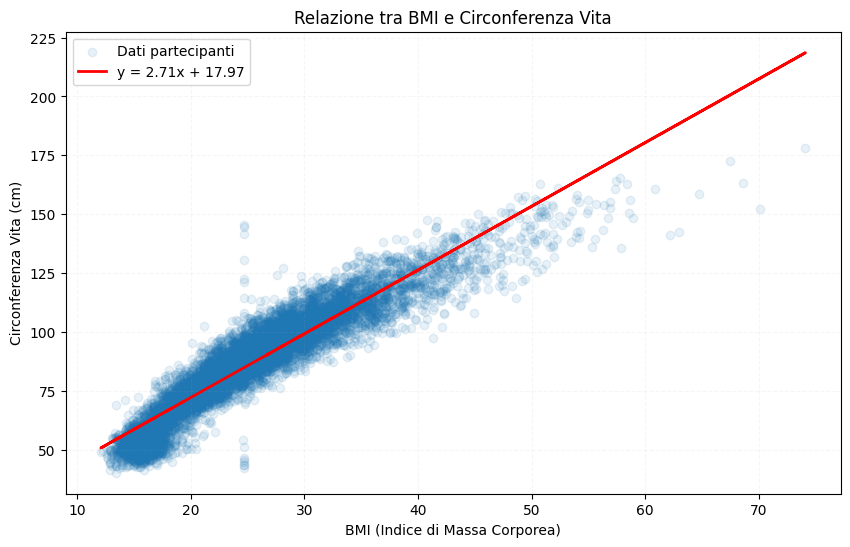

In [14]:
# Rimuoviamo i NaN solo per il calcolo della linea di tendenza
x = X.loc[X["BMI"].notna() & X["Circ_Vita"].notna(), "BMI"]
z = X.loc[X["BMI"].notna() & X["Circ_Vita"].notna(), "Circ_Vita"]

# Calcolo della linea di tendenza
# m = pendenza, q = intercetta
m, q = np.polyfit(x, z, 1)

plt.figure(figsize=(10, 6))

plt.scatter(x, z, alpha=0.1, label="Dati partecipanti")

# Linea di regressione
plt.plot(x, m*x + q, color="red", linewidth=2, label=f"y = {m:.2f}x + {q:.2f}")

plt.xlabel("BMI (Indice di Massa Corporea)")
plt.ylabel("Circonferenza Vita (cm)")
plt.title("Relazione tra BMI e Circonferenza Vita")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.1)

plt.show()

In [15]:
from sklearn.linear_model import LinearRegression
# Per i dati mancanti in Circ_Vita di è deciso di usare una regressione lineare basata sul BMI, siccome sono dati correlate
# Usiamo i dati presenti come dati di training e quelli mancanti come i dati di test
train_data = X[X["Circ_Vita"].notna() & X["BMI"].notna()]
test_data = X[X["Circ_Vita"].isna() & X["BMI"].notna()]

model_circ = LinearRegression()
model_circ.fit(train_data[["BMI"]], train_data["Circ_Vita"])

predicted_circ = model_circ.predict(test_data[["BMI"]])

X.loc[X["Circ_Vita"].isna() & X["BMI"].notna(), "Circ_Vita"] = predicted_circ

print(f"Dati mancanti rimasti in Circ_Vita: {X['Circ_Vita'].isna().sum()}")

Dati mancanti rimasti in Circ_Vita: 0


Per il colesterolo che dipende molto da età e sesso si è deciso di fare la mediana differenziando età e sesso.
Creiamo le fasce d'età (Giovani < 40, Adulti 40-60, Anziani > 60) che verra rimosso dopo le operazioni.

In [16]:
X["Fascia_Eta"] = pd.cut(X["Eta"], bins=[0, 40, 60, np.inf], labels=["Giovani", "Adulti", "Anziani"])

X["Colesterolo_HDL"] = X.groupby(["Sesso", "Fascia_Eta"])["Colesterolo_HDL"].transform(lambda x: x.fillna(x.median()))

# valore mediana
print(X.groupby(["Sesso", "Fascia_Eta"])["Colesterolo_HDL"].median().unstack())
print(f"Dati mancanti rimasti in Colesterolo_HDL: {X['Colesterolo_HDL'].isna().sum()}")

Fascia_Eta  Giovani  Adulti  Anziani
Sesso                               
1              49.0    46.0     46.0
2              53.0    55.0     57.0
Dati mancanti rimasti in Colesterolo_HDL: 0


C:\Users\Franco\AppData\Local\Temp\ipykernel_14652\3627847352.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X["Colesterolo_HDL"] = X.groupby(["Sesso", "Fascia_Eta"])["Colesterolo_HDL"].transform(lambda x: x.fillna(x.median()))
C:\Users\Franco\AppData\Local\Temp\ipykernel_14652\3627847352.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X.groupby(["Sesso", "Fascia_Eta"])["Colesterolo_HDL"].median().unstack())


Per gli Trigliceridi, dato che mancava il 60% di dati si è deciso di rimuovere la colonna

In [17]:
X = X.drop(columns=['Trigliceridi'])

Stesso ragionamento per il colesterolo

In [18]:
X["Sistolica_Media"] = X.groupby(["Sesso", "Fascia_Eta"])["Sistolica_Media"].transform(lambda x: x.fillna(x.median()))


# valore mediana
print(X.groupby(["Sesso", "Fascia_Eta"])["Sistolica_Media"].median().unstack())
X = X.drop(columns=['Fascia_Eta'])
print(f"Dati mancanti rimasti in Sistolica_Media: {X['Sistolica_Media'].isna().sum()}")

Fascia_Eta     Giovani      Adulti     Anziani
Sesso                                         
1           112.000000  123.333333  130.833333
2           106.666667  118.666667  132.000000
Dati mancanti rimasti in Sistolica_Media: 0


C:\Users\Franco\AppData\Local\Temp\ipykernel_14652\1820135460.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X["Sistolica_Media"] = X.groupby(["Sesso", "Fascia_Eta"])["Sistolica_Media"].transform(lambda x: x.fillna(x.median()))
C:\Users\Franco\AppData\Local\Temp\ipykernel_14652\1820135460.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X.groupby(["Sesso", "Fascia_Eta"])["Sistolica_Media"].median().unstack())


In [19]:
# percentuale di dati mancanti di fumatori e consumatori di alcol maggiorenni
missing_data = X[X["Eta"] > 18][["Eta", "Fumatore", "Consumo_Alcol"]]
missing_data = missing_data.isnull().mean() * 100
print(missing_data)

Eta               0.000000
Fumatore          6.381590
Consumo_Alcol    14.444263
dtype: float64


In [20]:
# percentuale di dati mancanti di fumatori e consumatori di alcol minorenni
missing_data = X[X["Eta"] < 18][["Eta", "Fumatore", "Consumo_Alcol"]]
missing_data = missing_data.isnull().mean() * 100
print(missing_data)

Eta                0.0
Fumatore         100.0
Consumo_Alcol    100.0
dtype: float64


Notiamo che i dati mancanti dei fumatori e consumatori di alcol sono principalmente minorenni, supponiamo che essi non fumino o bevino

In [21]:
cols_si_no = ['Attivita_Fisica', 'Fumatore', 'Consumo_Alcol']

# Trasformiamo 2 in 0 e 7/9 in NaN per tutte le colonne
for col in cols_si_no:
    X[col] = X[col].replace({2: 0, 7: np.nan, 9: np.nan})

# Supponiamo che i minorenni non bevano e fumano
X.loc[X["Eta"] < 18, "Fumatore"] = 0
X.loc[X["Eta"] < 18, "Consumo_Alcol"] = 0
# indichiamo con 2 il significato di dato mancante
X["Attivita_Fisica"] = X["Attivita_Fisica"].fillna(2)

print(f"Dati mancanti rimasti in Attivita_Fisica: {X['Attivita_Fisica'].isna().sum()}")
print(f"Dati mancanti rimasti in Fumatore: {X['Fumatore'].isna().sum()}")
print(f"Dati mancanti rimasti in Consumo_Alcol: {X['Consumo_Alcol'].isna().sum()}")

# si è riempito i valori mancanti con la moda di maggiorenni
moda_fumatore = X.loc[X["Eta"] > 18, "Fumatore"].mode()[0]
moda_alcol = X.loc[X["Eta"] > 18, "Consumo_Alcol"].mode()[0]

X["Fumatore"] = X["Fumatore"].fillna(moda_fumatore)
X["Consumo_Alcol"] = X["Consumo_Alcol"].fillna(moda_alcol)

print(f"Dati mancanti rimasti in Fumatore: {X['Fumatore'].isna().sum()}")
print(f"Dati mancanti rimasti in Consumo_Alcol: {X['Consumo_Alcol'].isna().sum()}")


Dati mancanti rimasti in Attivita_Fisica: 0
Dati mancanti rimasti in Fumatore: 393
Dati mancanti rimasti in Consumo_Alcol: 902
Dati mancanti rimasti in Fumatore: 0
Dati mancanti rimasti in Consumo_Alcol: 0


In [22]:
missing_data = X.isnull().mean() * 100
print("Dati mancanti: ")
print(missing_data)

Dati mancanti: 
Eta                0.0
Sesso              0.0
Etnia              0.0
BMI                0.0
Circ_Vita          0.0
Colesterolo_HDL    0.0
Sistolica_Media    0.0
Attivita_Fisica    0.0
Fumatore           0.0
Consumo_Alcol      0.0
dtype: float64


# 3. Esplorazione dei dati

In [23]:
X.head()

,Eta,Sesso,Etnia,BMI,Circ_Vita,Colesterolo_HDL,Sistolica_Media,Attivita_Fisica,Fumatore,Consumo_Alcol
0,69,1,4,26.7,100.000000,65.0,112.666667,0.0,1.0,1.0
1,54,1,3,28.6,107.600000,50.0,157.333333,0.0,1.0,1.0
2,72,1,3,28.9,109.200000,60.0,142.000000,0.0,1.0,1.0
3,9,1,3,17.1,61.000000,61.0,104.666667,2.0,0.0,0.0
4,73,2,3,19.7,71.297584,85.0,137.333333,0.0,0.0,1.0


Nello specifico, le __features__ disponibile sono:

1. Age | Objective Feature | int (years) |
2. Sesso | Objective Feature | 1:Maschio, 2:Femmina |
3. Etnia | Objective Feature | Categorica (Codine NHANES) |
4. BMI | Examination Feature | kg/m^2 |
5. Circonferenza Vita  | Examination Feature | float (cm) |
6. Colesterolo HDL | Examination Feature | int (mg/dL) |
7. Pressione sistolica | Examination Feature | float |
8. Attività Fisica | Subjective Feature | gluc | 0: No 1: Yes, 2: No data |
9. Fumatore | Subjective Feature | Binario |
10. Consumo Alcol | Subjective Feature | Binario |


In [24]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Eta,9813.0,32.705391,23.559942,1.000000,12.000000,27.0,52.000000,80.000000
Sesso,9813.0,1.507694,0.499966,1.000000,1.000000,2.0,2.000000,2.000000
Etnia,9813.0,3.083766,1.262812,1.000000,2.000000,3.0,4.000000,5.000000
BMI,9813.0,25.602680,7.646147,12.100000,20.200000,24.7,29.600000,82.900000
Circ_Vita,9813.0,87.274989,22.034011,40.200000,72.800000,85.5,101.500000,242.367672
Colesterolo_HDL,9813.0,52.627841,13.500905,10.000000,45.000000,51.0,58.000000,173.000000
Sistolica_Media,9813.0,116.469564,16.301115,64.666667,106.666667,112.0,123.333333,228.666667
Attivita_Fisica,9813.0,0.700092,0.890932,0.000000,0.000000,0.0,2.000000,2.000000
Fumatore,9813.0,0.253745,0.435176,0.000000,0.000000,0.0,1.000000,1.000000
Consumo_Alcol,9813.0,0.478141,0.499547,0.000000,0.000000,0.0,1.000000,1.000000


In [25]:
# Controllo valori distinti per variabili categoriche
for col in ["Sesso", "Etnia", "Attivita_Fisica", "Fumatore", "Consumo_Alcol"]:
    print(f"\nDistribuzione {col}:")
    print(X[col].value_counts(normalize=True) * 100)


Distribuzione Sesso:
Sesso
2    50.769388
1    49.230612
Name: proportion, dtype: float64

Distribuzione Etnia:
Etnia
3    36.054214
4    22.398859
1    17.171100
5    14.898604
2     9.477224
Name: proportion, dtype: float64

Distribuzione Attivita_Fisica:
Attivita_Fisica
0.0    59.176602
2.0    29.185774
1.0    11.637624
Name: proportion, dtype: float64

Distribuzione Fumatore:
Fumatore
0.0    74.625497
1.0    25.374503
Name: proportion, dtype: float64

Distribuzione Consumo_Alcol:
Consumo_Alcol
0.0    52.185876
1.0    47.814124
Name: proportion, dtype: float64


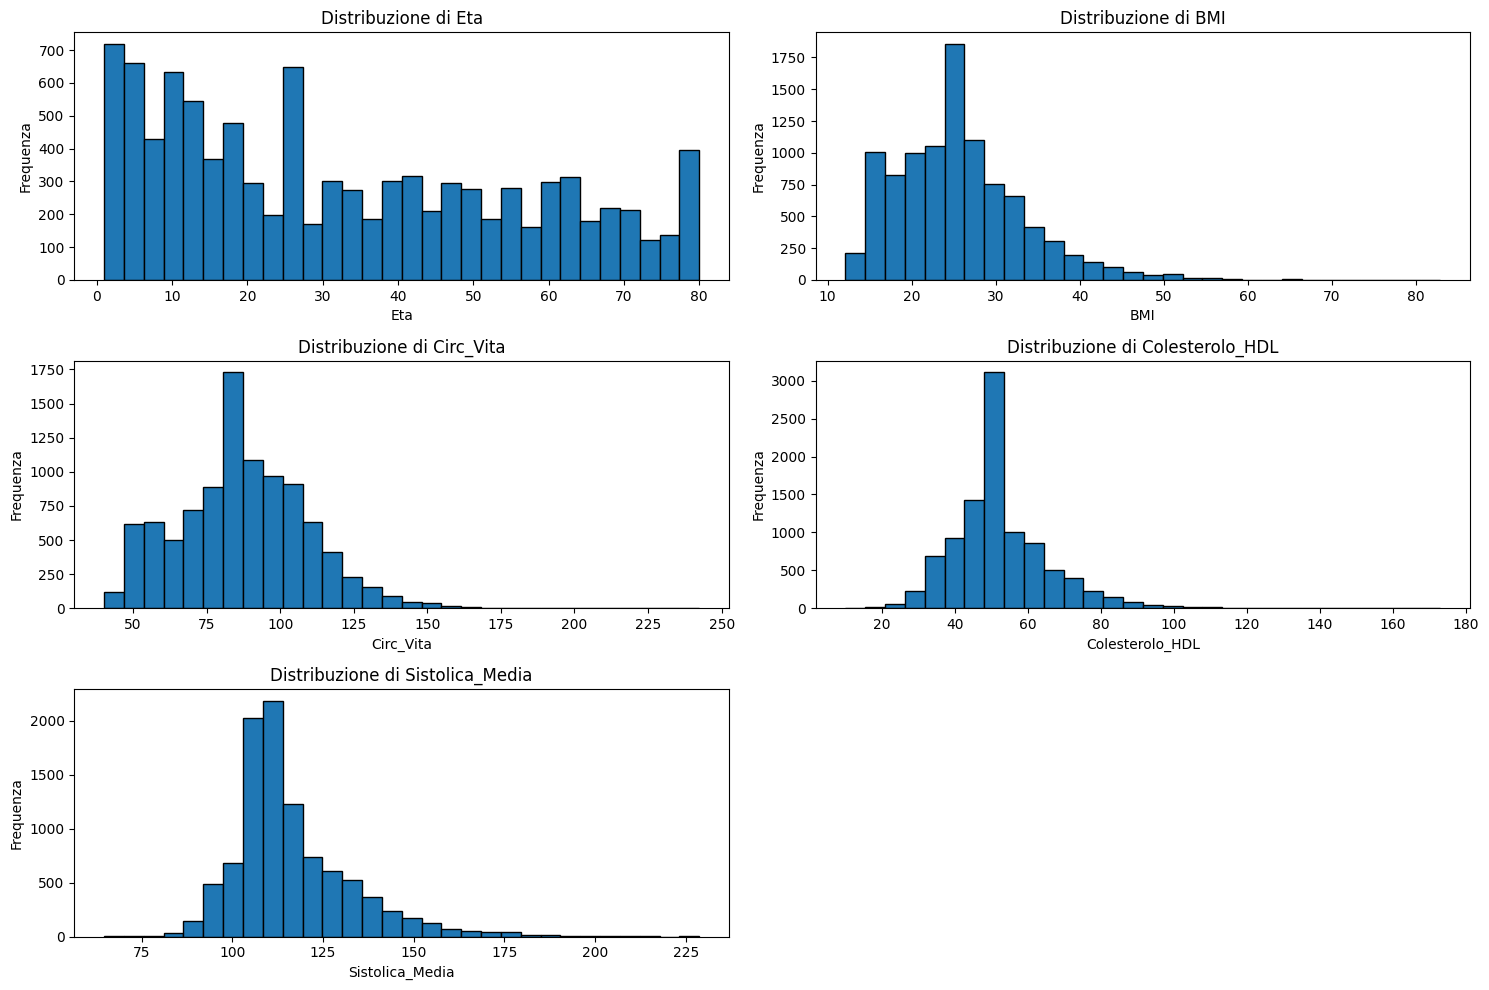

In [26]:
cols_num = ["Eta", "BMI", "Circ_Vita", "Colesterolo_HDL", "Sistolica_Media"]
plt.figure(figsize=(15, 10))

for i, col in enumerate(cols_num, 1):
    plt.subplot(3, 2, i)
    plt.hist(X[col], bins=30, edgecolor="black")
    plt.title(f"Distribuzione di {col}")
    plt.xlabel(col)
    plt.ylabel("Frequenza")

plt.tight_layout()
plt.show()

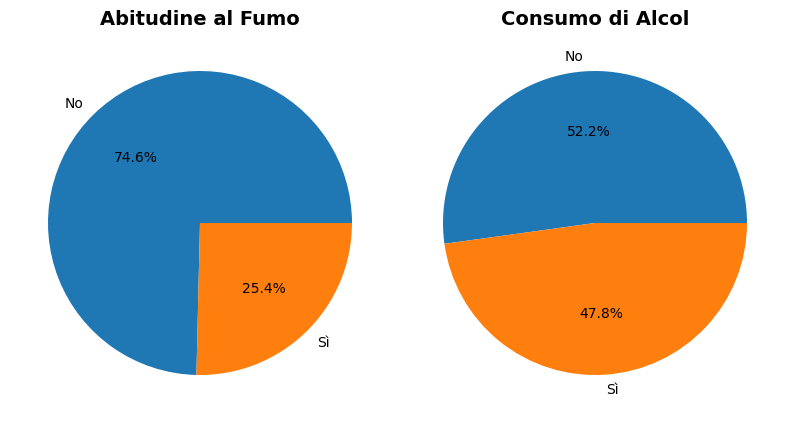

In [27]:
# Definizione dei dati e delle etichette
variabili = ["Fumatore", "Consumo_Alcol"]
titoli = ["Abitudine al Fumo", "Consumo di Alcol"]
labels = ["No", "Sì"]

plt.figure(figsize=(12, 6))

for i, var in enumerate(variabili):
    plt.subplot(1, 3, i+1)
    
    counts = X[var].value_counts()
    
    plt.pie(counts, 
            labels=labels, 
            autopct="%1.1f%%")
    
    plt.title(titoli[i], fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

def valuta_modello(nome, modello, X_test, y_test):
    y_pred = modello.predict(X_test)
    score = modello.score(X_test, y_test)
    print(f"Accuracy del modello: {score:.4f}")
    print(f"\nPerformance {nome}")
    print(classification_report(y_test, y_pred))
    print("Matrice di Confusione:")
    print(confusion_matrix(y_test, y_pred))

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Perceptron



# 2. Divisione Training e Test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


pc_std = Pipeline([
    ("scale", StandardScaler()),
    ("perceptron", Perceptron(max_iter=1000, tol=1e-3, random_state=42))
])

pc_std.fit(X_train, y_train)

,steps,"[('scale', ...), ('perceptron', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True


In [30]:
valuta_modello("Perceptron", pc_std, X_test, y_test)

Accuracy del modello: 0.8915

Performance Perceptron
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1789
           1       0.33      0.22      0.27       174

    accuracy                           0.89      1963
   macro avg       0.63      0.59      0.60      1963
weighted avg       0.87      0.89      0.88      1963

Matrice di Confusione:
[[1711   78]
 [ 135   39]]


In [74]:
def show_feature_importance(model, named_step, name , X):
    weight = model.named_steps[named_step].coef_[0]
    feature_names = X.columns

    df = pd.DataFrame({"Feature": feature_names, "Pesi": weight})
    df = df.sort_values(by="Pesi", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(df["Feature"], df["Pesi"])
    plt.title(f"Pesi dei Coefficienti: {name}")
    plt.xlabel("Importanza Relativa")
    plt.show()

-14.0


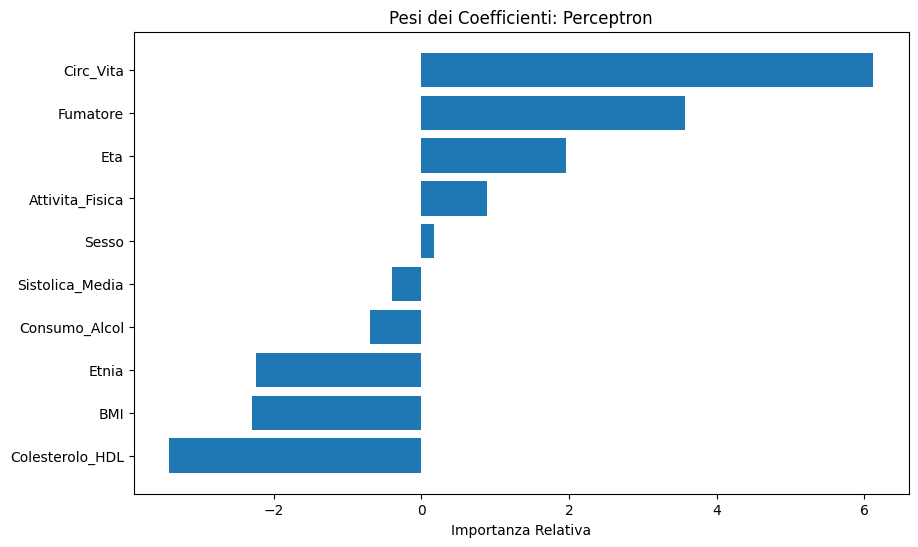

In [67]:
print(pc_std.named_steps["perceptron"].intercept_[0])
show_feature_importance(pc_std, "perceptron", "Perceptron", X)

In [ ]:
lr_std =  Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=42))
])
lr_std.fit(X_train, y_train)

,steps,"[('scaler', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [39]:
valuta_modello("Logistic Regression", lr_std, X_test, y_test)

Accuracy del modello: 0.9139

Performance Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1789
           1       0.55      0.16      0.25       174

    accuracy                           0.91      1963
   macro avg       0.74      0.57      0.60      1963
weighted avg       0.89      0.91      0.89      1963

Matrice di Confusione:
[[1766   23]
 [ 146   28]]


-3.761549485362058


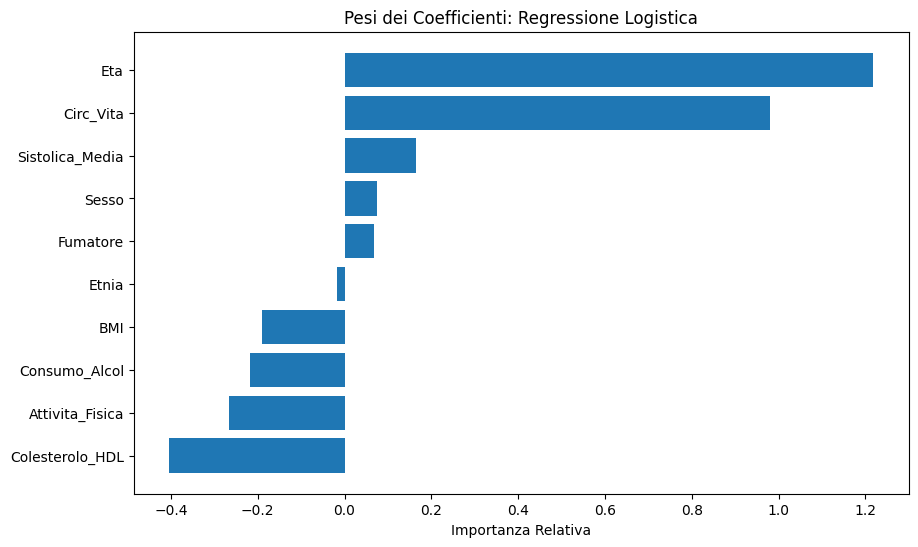

In [69]:
print(lr_std.named_steps["logreg"].intercept_[0])
show_feature_importance(lr_std, "logreg", "Regressione Logistica", X)

I due risultati hanno ottenuto entrambi un accuratezza del 90%, ma questo risultato è ingannevole causata dallo sbilanciamento dei sani vs diabetici (90-10). Quindi entrambi i modelli per andare sul sicuro tende a valutare che la persona sia sana, infatti notiamo che il valore di recall dei diabetici è del 0.16-0.22. Per forzare i modelli a dare maggiore importanza alla casse minoritaria proviamo a usare il parametro __class_weight="balanced"__

In [47]:
pc_bal = Pipeline([
    ("scale", StandardScaler()),
    ("perceptron", Perceptron(max_iter=1000, tol=1e-3, class_weight="balanced", random_state=42))
])

pc_bal.fit(X_train, y_train)

,steps,"[('scale', ...), ('perceptron', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True


In [48]:
valuta_modello("Perceptron", pc_bal, X_test, y_test)

Accuracy del modello: 0.6689

Performance Perceptron
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1789
           1       0.19      0.87      0.32       174

    accuracy                           0.67      1963
   macro avg       0.59      0.76      0.55      1963
weighted avg       0.91      0.67      0.74      1963

Matrice di Confusione:
[[1161  628]
 [  22  152]]


-16.272082908658064


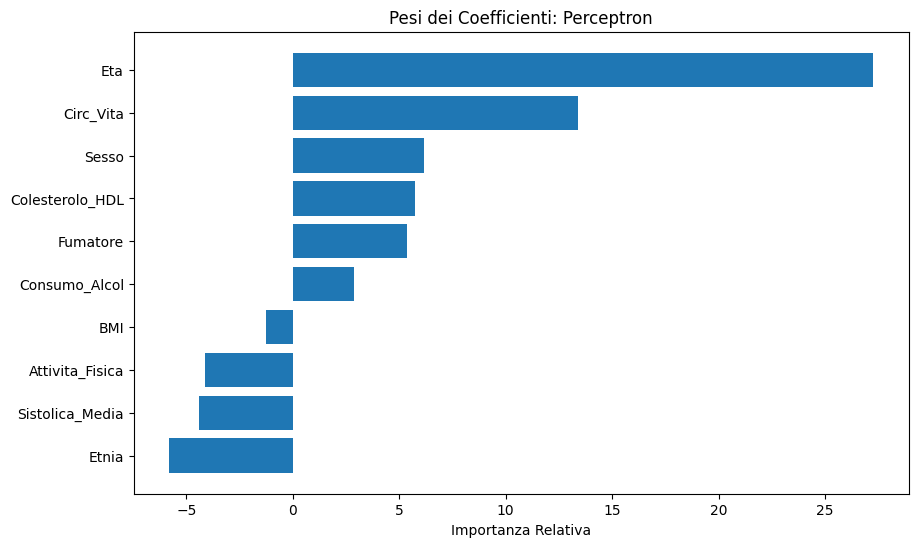

In [72]:
print(pc_bal.named_steps["perceptron"].intercept_[0])
show_feature_importance(pc_bal, "perceptron", "Perceptron", X)

In [50]:
lr_bal =  Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(class_weight="balanced", random_state=42))
])
lr_bal.fit(X_train, y_train)

,steps,"[('scaler', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [51]:
valuta_modello("Logistic Regression", lr_bal, X_test, y_test)

Accuracy del modello: 0.7708

Performance Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      1789
           1       0.26      0.86      0.40       174

    accuracy                           0.77      1963
   macro avg       0.62      0.81      0.63      1963
weighted avg       0.92      0.77      0.82      1963

Matrice di Confusione:
[[1363  426]
 [  24  150]]


-1.6148792432136447


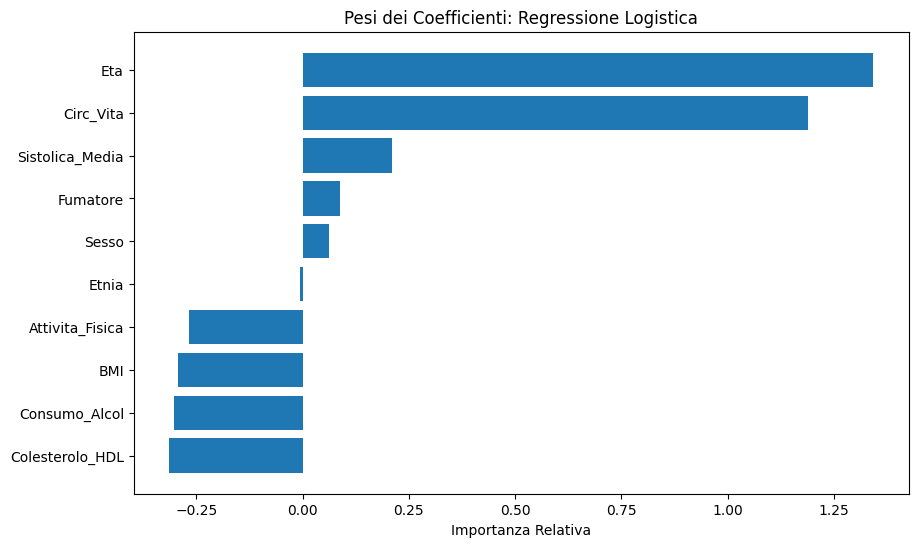

In [73]:
print(lr_bal.named_steps["logreg"].intercept_[0])
show_feature_importance(lr_bal, "logreg", "Regressione Logistica", X)

Con il bilanciamento dei pesi abbiamo ottenuto maggiore accuratezza nel individuare i diabetici, aumentando la recall a circa del 0.86-0.87. In un contesto medico, questo è un risultato migliore rispetto a considerare un diabetico come sano. Infatti si nota che il numero di falsi positivi sono aumentati in entrambi i modelli.

In [53]:
from sklearn.svm import SVC

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42))
])

svm.fit(X_train, y_train)

,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(class_weight="balanced", random_state=42))
])

rf.fit(X_train, y_train)


,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [76]:
valuta_modello("SVM", svm, X_test, y_test)
valuta_modello("Random Forest", rf, X_test, y_test)

Accuracy del modello: 0.7585

Performance SVM
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1789
           1       0.25      0.84      0.38       174

    accuracy                           0.76      1963
   macro avg       0.61      0.80      0.62      1963
weighted avg       0.92      0.76      0.81      1963

Matrice di Confusione:
[[1342  447]
 [  27  147]]
Accuracy del modello: 0.9063

Performance Random Forest
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1789
           1       0.39      0.10      0.16       174

    accuracy                           0.91      1963
   macro avg       0.65      0.54      0.56      1963
weighted avg       0.87      0.91      0.88      1963

Matrice di Confusione:
[[1761   28]
 [ 156   18]]


Il SVM ha ottenuto risultati simili alla Logistig regression, invece la random forest nonostante il bilanciamento delle classi ha comunque dato priorità all'accuratezza.

In [77]:
y_probs_rf = rf.predict_proba(X_test)[:, 1]
soglie = [0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
risultati = []
for s in soglie:
    y_pred_temp = (y_probs_rf >= s).astype(int)
    
    # Estraiamo precision e recall per la classe 1 (diabetici)
    report = classification_report(y_test, y_pred_temp, output_dict=True)
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    f1 = report["1"]["f1-score"]
    
    risultati.append({
        "Soglia": s,
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1-Score": round(f1, 2)
    })

df_confronto = pd.DataFrame(risultati)
print(df_confronto)

   Soglia  Precision  Recall  F1-Score
0    0.05       0.22    0.92      0.35
1    0.07       0.23    0.90      0.37
2    0.09       0.25    0.87      0.38
3    0.10       0.24    0.83      0.38
4    0.20       0.33    0.66      0.44
5    0.30       0.36    0.41      0.39
6    0.40       0.39    0.25      0.30
7    0.50       0.41    0.11      0.18


Modificando un po' le soglie vediamo che mantenendo la stessa precisione del SVM (0.25) si ottiene una recall leggermente maggiore con la random forest.

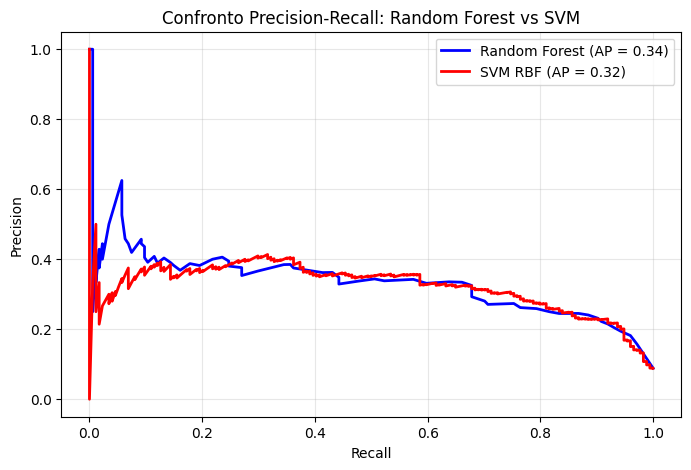

In [59]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_probs_rf = rf.predict_proba(X_test)[:, 1]
y_probs_svm = svm.predict_proba(X_test)[:, 1]

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_probs_rf)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_probs_svm)

ap_rf = average_precision_score(y_test, y_probs_rf)
ap_svm = average_precision_score(y_test, y_probs_svm)

plt.figure(figsize=(8, 5))
plt.plot(recall_rf, precision_rf, label=f"Random Forest (AP = {ap_rf:.2f})", color="blue", lw=2)
plt.plot(recall_svm, precision_svm, label=f"SVM RBF (AP = {ap_svm:.2f})", color="red", lw=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Confronto Precision-Recall: Random Forest vs SVM")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()

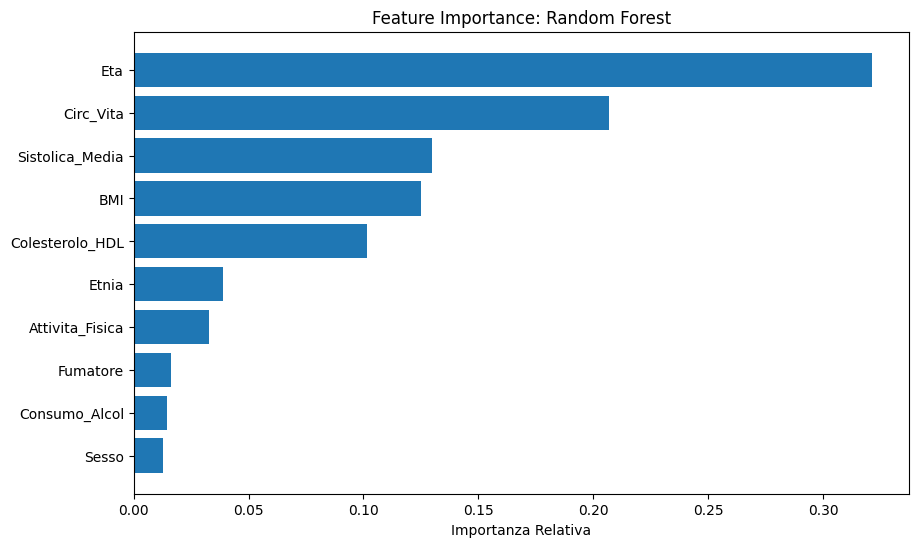

In [ ]:
# Importanza degli features per la random forest
importances_rf = rf.named_steps["rf"].feature_importances_
feature_names = X.columns

df_rf = pd.DataFrame({"Feature": feature_names, "Importance": importances_rf})
df_rf = df_rf.sort_values(by="Importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df_rf["Feature"], df_rf["Importance"])
plt.title("Feature Importance: Random Forest")
plt.xlabel("Importanza Relativa")
plt.show()

| Modello | Bilanciamento | Accuracy | Precision | Recall | F1-Score |
| :--- | :---: | :---: | :---: | :---: |:---: |
| Perceptron std | No | 0.89 | 0.33 | 0.22 | 0.27 |
| Logistic Regression  std | No | 0.91 | 0.55 | 0.16 | 0.25 |
| Perceptron bal | Si | 0.67 | 0.19 | 0.87 | 0.32 |
| Logistic Regression  bal | Si | 0.77 | 0.26 | 0.86 | 0.40 |
| SVM (RBF) | Si |0.76 | 0.25 | 0.84 | 0.38 |
| Random Forest | Soglia 0.09 |0.75 | 0.25 | 0.87 | 0.38 |